In [1]:
import torch
from pathlib import Path
import os
from sklearn.metrics import r2_score
import time
import datetime
import numpy as np
import matplotlib.pyplot as plt

from Model_simple import *
from Unet_model import *
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import normalized_root_mse as nrmse
from skimage.metrics import mean_squared_error as mse


In [2]:
device = torch.device('cuda')
test_model = InceptionLSTM(3, 1, 128, 60, 0.3).float().to(device)
test_model.load_state_dict(torch.load(f'model_weights_10.30-15.28_s@84.pth', map_location=device))    # [notice] match !!
test_model.eval()
print('done')

def ax_imshow(ax_to_plot, variable, v_min, v_max):
    variable = variable * 0.87943658597
    pcm = ax_to_plot.imshow(variable, cmap='jet', vmin=v_min, vmax=v_max)
    return pcm

def infer_show(ax_to_plot, ccc, ts, v_min, v_max):
    input_tensor = torch.load(f'geo_train_s_x\\{ccc:>04}.pt').to(device).squeeze()
    variable, _ = test_model(input_tensor.float().unsqueeze(0))
    variable = variable.squeeze().detach().cpu()
    variable = variable[ts, :, :]
    variable = variable * 0.87943658597
    pcm = ax_to_plot.imshow(variable, cmap='jet', vmin=v_min, vmax=v_max)
    return pcm

def res_show(ax_to_plot, ccc, ts, v_min=0, v_max=0.2):
    input_tensor = torch.load(f'geo_train_s_x\\{ccc:>04}.pt').to(device).squeeze()
    variable, _ = test_model(input_tensor.float().unsqueeze(0))
    variable = variable.squeeze().detach().cpu()
    variable = variable[ts, :, :]
    variable = variable * 0.87943658597
    
    p_path = Path(f'C:\\dynamic\\fffinal\\deep_test_tensors\\test_geo\\label_s')
    target = torch.load(p_path / f'{ccc:>04}_{(ts+1)*30:.1f}_label_s.pt')
    target = target * 0.87943658597
    target, variable = target.numpy(), variable.numpy()
    data_range = np.max(target) - np.min(target)
    # v2 = ssim(target, variable, data_range=data_range, gaussian_weights=True, sigma=1.5)
    v2 = ssim(target, variable, data_range=1.0)
    v1 = r2_score(target.flatten(), variable.flatten(), multioutput='variance_weighted')
    res = np.abs(target - variable) / np.max(target)
    pcm = ax_to_plot.imshow(res, cmap='jet', vmin=v_min, vmax=v_max)
    t = ax_to_plot.text(1.2, 8.5, f'$R^2$={v1:.3f}\nSSIM={v2:.3f}', c='white')
    t.set_fontsize(16)
    t.set_fontweight('semibold')
    return pcm


def u_infer(ax_to_plot, bbb, ts, v_min, v_max):
    device = torch.device('cuda')
    input_tensor = torch.load(f'geo_Unet_train_s_x\\{bbb:>04}_{ts}.pt').to(device).unsqueeze(0)
    u_model = UNET(in_channels=4, out_channels=1).float().to(device)
    u_model.load_state_dict(torch.load(f'Unet_model_weights_10.12_s.pth', map_location=device))    # [notice] match !!
    u_model.eval()
    pred = u_model(input_tensor).squeeze().detach().cpu()
    pred = pred * 0.87943658597
    pcm = ax_to_plot.imshow(pred, cmap='jet', vmin=v_min, vmax=v_max)
    return pcm

def u_res(ax_to_plot, bbb, ts, v_min=0, v_max=0.2):
    device = torch.device('cuda')
    input_tensor = torch.load(f'geo_Unet_train_s_x\\{bbb:>04}_{ts}.pt').to(device).unsqueeze(0)
    u_model = UNET(in_channels=4, out_channels=1).float().to(device)
    u_model.load_state_dict(torch.load(f'Unet_model_weights_10.12_s.pth', map_location=device))    # [notice] match !!
    u_model.eval()
    pred = u_model(input_tensor).squeeze().detach().cpu()
    target = torch.load(f'geo_Unet_train_s_y\\{bbb:>04}_{ts}.pt').squeeze()
    pred = pred * 0.87943658597
    target = target * 0.87943658597
    res = torch.abs(target - pred) / torch.max(target)
    pcm = ax_to_plot.imshow(res, cmap='jet', vmin=v_min, vmax=v_max)
    target, pred = target.numpy(), pred.numpy()
    data_range = np.max(target) - np.min(target)
    # v2 = ssim(target, pred, data_range=data_range, gaussian_weights=True, sigma=1.5)
    v2 = ssim(target, pred, data_range=1.0)
    v1 = r2_score(target.flatten(), pred.flatten(), multioutput='variance_weighted')
    t = ax_to_plot.text(1.2, 8.5, f'$R^2$={v1:.3f}\nSSIM={v2:.3f}', c='white')
    
    t.set_fontsize(16)
    t.set_fontweight('semibold')
    return pcm

done


In [19]:
fig, axs = plt.subplots(5, 5, figsize=(23.1, 18), dpi=300, layout='constrained')

for ax in axs.flatten():
    ax.set_xticks([])
    ax.set_yticks([])
    
p_path = Path(f'C:\\dynamic\\fffinal\\deep_test_tensors\\test_geo\\label_s')

case_num = 8007
v1_min = 0.
v1_max = 0.7

pcm = ax_imshow(axs[0, 0], torch.load(p_path / f'{case_num:>04}_360.0_label_s.pt'), v1_min, v1_max)
_ = ax_imshow(axs[0, 1], torch.load(p_path / f'{case_num:>04}_720.0_label_s.pt'), v1_min, v1_max)
_ = ax_imshow(axs[0, 2], torch.load(p_path / f'{case_num:>04}_1080.0_label_s.pt'), v1_min, v1_max)
_ = ax_imshow(axs[0, 3], torch.load(p_path / f'{case_num:>04}_1440.0_label_s.pt'), v1_min, v1_max)
_ = ax_imshow(axs[0, 4], torch.load(p_path / f'{case_num:>04}_1800.0_label_s.pt'), v1_min, v1_max)

_ = infer_show(axs[1, 0], case_num, 11, v1_min, v1_max)
_ = infer_show(axs[1, 1], case_num, 23, v1_min, v1_max)
_ = infer_show(axs[1, 2], case_num, 35, v1_min, v1_max)
_ = infer_show(axs[1, 3], case_num, 47, v1_min, v1_max)
_ = infer_show(axs[1, 4], case_num, 59, v1_min, v1_max)

_ = u_infer(axs[2, 0], case_num, 11, v1_min, v1_max)
_ = u_infer(axs[2, 1], case_num, 23, v1_min, v1_max)
_ = u_infer(axs[2, 2], case_num, 35, v1_min, v1_max)
_ = u_infer(axs[2, 3], case_num, 47, v1_min, v1_max)
_ = u_infer(axs[2, 4], case_num, 59, v1_min, v1_max)

res_pcm = res_show(axs[3, 0], case_num, 11,)
_ = res_show(axs[3, 1], case_num, 23,)
_ = res_show(axs[3, 2], case_num, 35,)
_ = res_show(axs[3, 3], case_num, 47,)
_ = res_show(axs[3, 4], case_num, 59,)

_ = u_res(axs[4, 0], case_num, 11)
_ = u_res(axs[4, 1], case_num, 23)
_ = u_res(axs[4, 2], case_num, 35)
_ = u_res(axs[4, 3], case_num, 47)
_ = u_res(axs[4, 4], case_num, 59)


cbar1 = fig.colorbar(res_pcm, ax=axs.ravel().tolist(), shrink=0.55)
cbar2 = fig.colorbar(pcm, ax=axs.ravel().tolist(), shrink=0.55)
cbar1.ax.tick_params(labelsize=30)
cbar2.ax.tick_params(labelsize=30)
cbar1.ax.set_yticklabels(["{:.1%}".format(i) for i in cbar1.get_ticks()])
plt.savefig('chutu\\sat_geo.tiff', dpi=600, bbox_inches='tight', pad_inches=0.1)
plt.close()

C:\Users\pc\AppData\Local\Temp\ipykernel_20628\3149884887.py:48: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cbar1.ax.set_yticklabels(["{:.1%}".format(i) for i in cbar1.get_ticks()])


In [16]:
def plot_tmp(cc):
    fig, axs = plt.subplots(5, 5, figsize=(23.1, 18), dpi=50, layout='constrained')
    
    for ax in axs.flatten():
        ax.set_xticks([])
        ax.set_yticks([])
    
    p_path = Path(f'C:\\dynamic\\fffinal\\deep_test_tensors\\test_geo\\label_s')
    
    case_num = cc
    v1_min = 0.
    v1_max = 0.7
    
    pcm = ax_imshow(axs[0, 0], torch.load(p_path / f'{case_num:>04}_360.0_label_s.pt'), v1_min, v1_max)
    _ = ax_imshow(axs[0, 1], torch.load(p_path / f'{case_num:>04}_720.0_label_s.pt'), v1_min, v1_max)
    _ = ax_imshow(axs[0, 2], torch.load(p_path / f'{case_num:>04}_1080.0_label_s.pt'), v1_min, v1_max)
    _ = ax_imshow(axs[0, 3], torch.load(p_path / f'{case_num:>04}_1440.0_label_s.pt'), v1_min, v1_max)
    _ = ax_imshow(axs[0, 4], torch.load(p_path / f'{case_num:>04}_1800.0_label_s.pt'), v1_min, v1_max)
    
    _ = infer_show(axs[1, 0], case_num, 11, v1_min, v1_max)
    _ = infer_show(axs[1, 1], case_num, 23, v1_min, v1_max)
    _ = infer_show(axs[1, 2], case_num, 35, v1_min, v1_max)
    _ = infer_show(axs[1, 3], case_num, 47, v1_min, v1_max)
    _ = infer_show(axs[1, 4], case_num, 59, v1_min, v1_max)
    
    _ = u_infer(axs[2, 0], case_num, 11, v1_min, v1_max)
    _ = u_infer(axs[2, 1], case_num, 23, v1_min, v1_max)
    _ = u_infer(axs[2, 2], case_num, 35, v1_min, v1_max)
    _ = u_infer(axs[2, 3], case_num, 47, v1_min, v1_max)
    _ = u_infer(axs[2, 4], case_num, 59, v1_min, v1_max)
    
    res_pcm = res_show(axs[3, 0], case_num, 11,)
    _ = res_show(axs[3, 1], case_num, 23,)
    _ = res_show(axs[3, 2], case_num, 35,)
    _ = res_show(axs[3, 3], case_num, 47,)
    _ = res_show(axs[3, 4], case_num, 59,)
    
    _ = u_res(axs[4, 0], case_num, 11)
    _ = u_res(axs[4, 1], case_num, 23)
    _ = u_res(axs[4, 2], case_num, 35)
    _ = u_res(axs[4, 3], case_num, 47)
    _ = u_res(axs[4, 4], case_num, 59)
    
    
    cbar1 = fig.colorbar(res_pcm, ax=axs.ravel().tolist(), shrink=0.55)
    cbar2 = fig.colorbar(pcm, ax=axs.ravel().tolist(), shrink=0.55)
    cbar1.ax.tick_params(labelsize=30)
    cbar2.ax.tick_params(labelsize=30)
    cbar1.ax.set_yticklabels(["{:.1%}".format(i) for i in cbar1.get_ticks()])
    plt.savefig(f'chutu\\tmp_sat\\sat_geo_{case_num}.jpg', dpi=50, bbox_inches='tight', pad_inches=0.1)
    # plt.close()

C:\Users\pc\AppData\Local\Temp\ipykernel_20628\341856582.py:49: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cbar1.ax.set_yticklabels(["{:.1%}".format(i) for i in cbar1.get_ticks()])
C:\Users\pc\AppData\Local\Temp\ipykernel_20628\341856582.py:49: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cbar1.ax.set_yticklabels(["{:.1%}".format(i) for i in cbar1.get_ticks()])
C:\Users\pc\AppData\Local\Temp\ipykernel_20628\341856582.py:49: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cbar1.ax.set_yticklabels(["{:.1%}".format(i) for i in cbar1.get_ticks()])
C:\Users\pc\AppData\Local\Temp\ipykernel_20628\341856582.py:49: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cb

KeyboardInterrupt: 

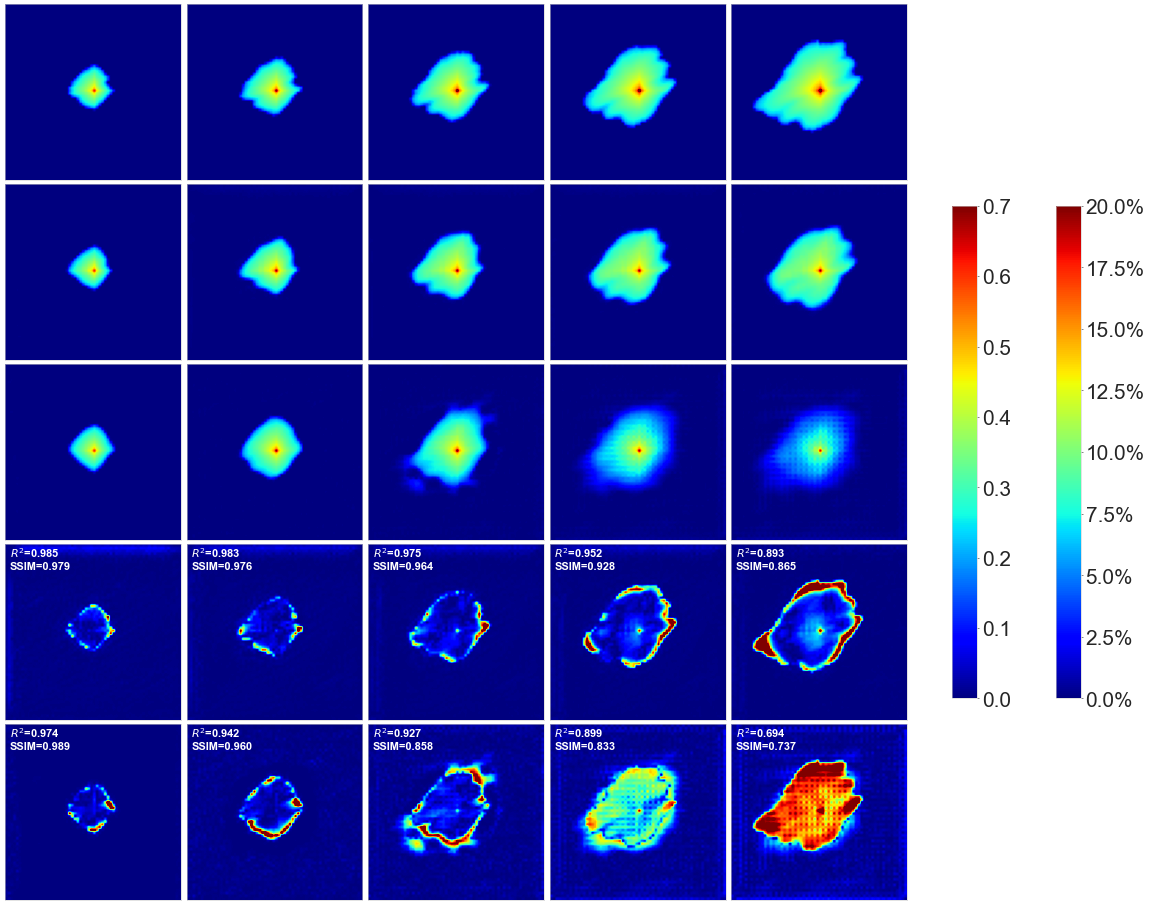

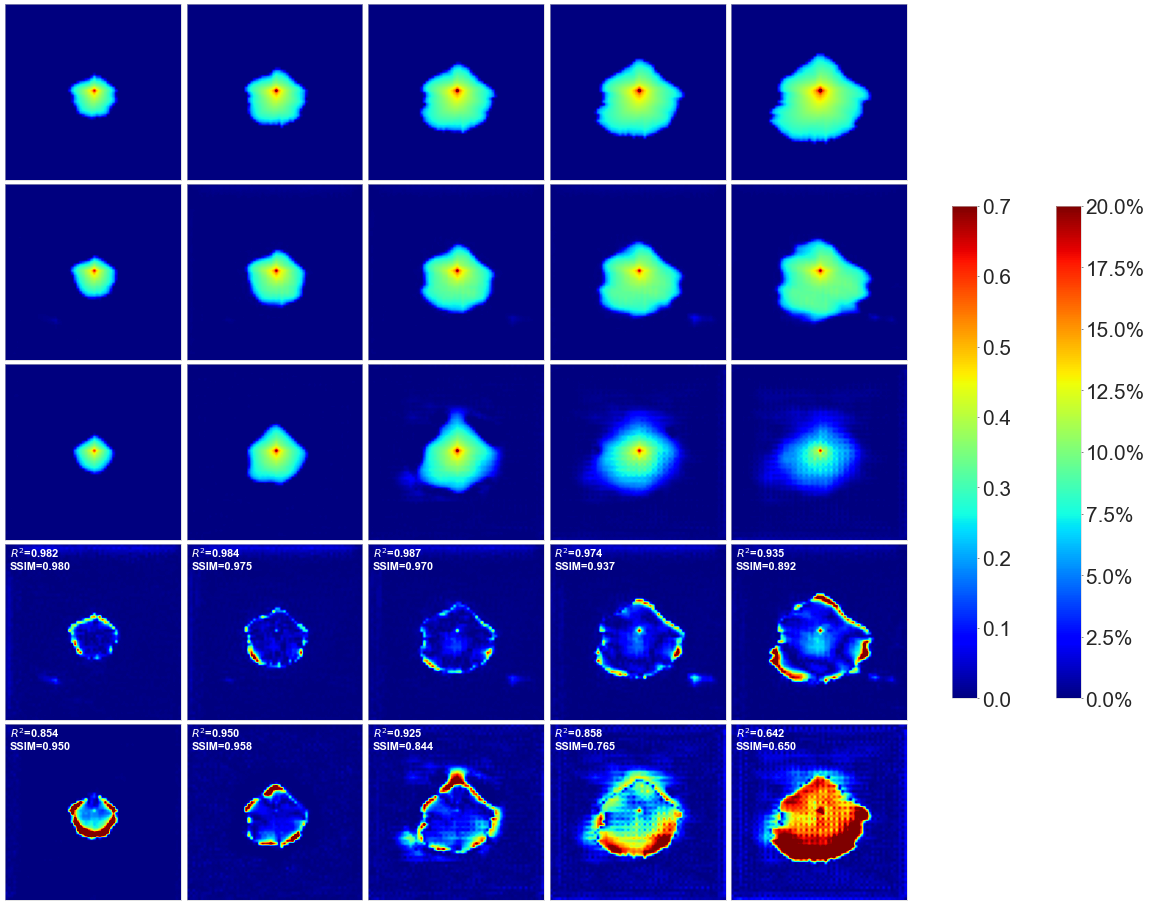

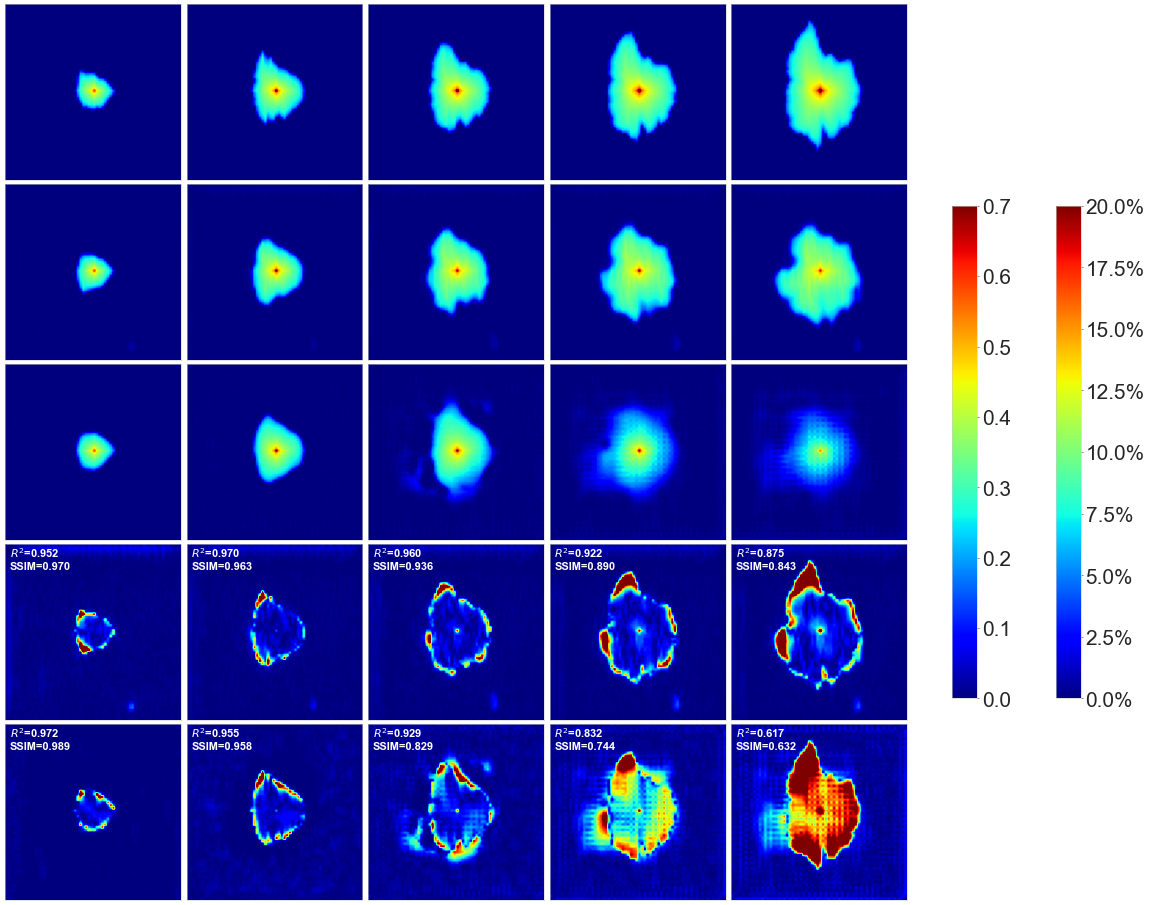

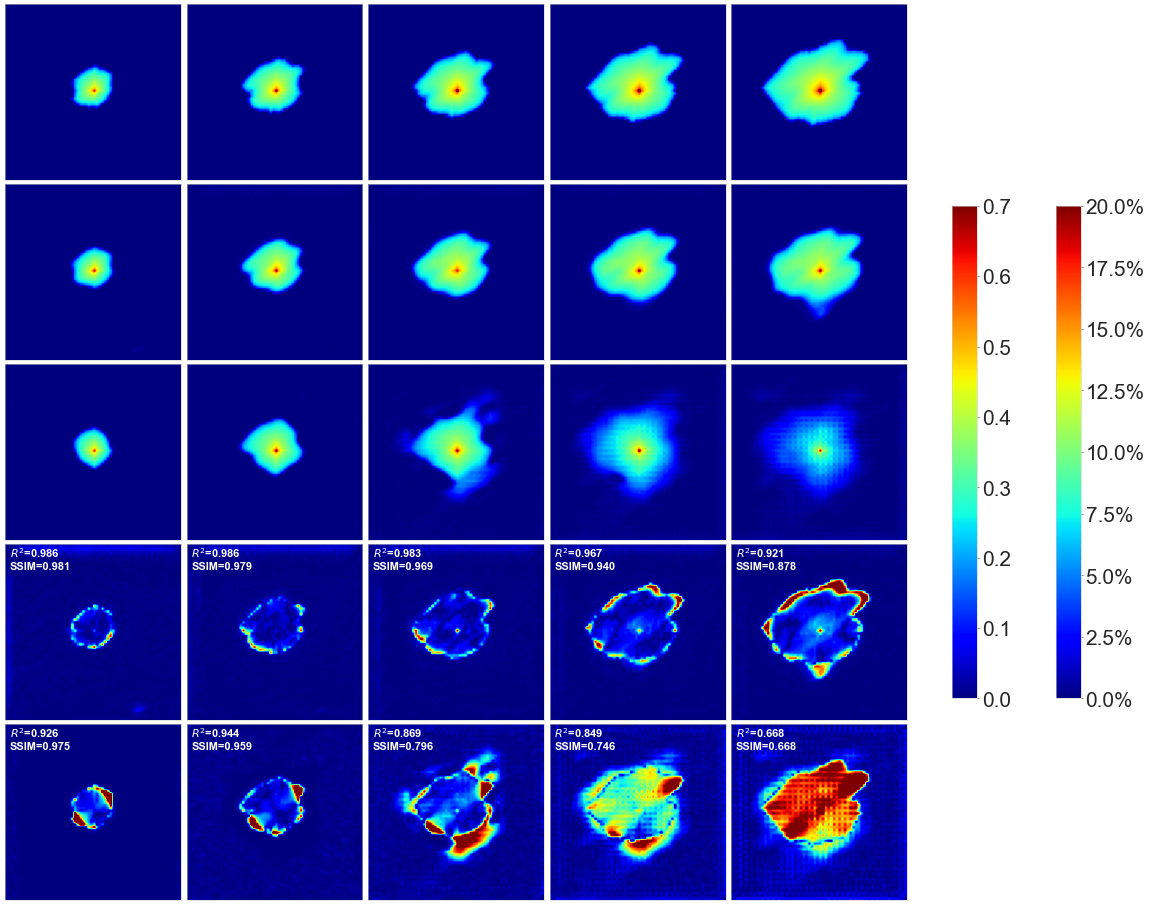

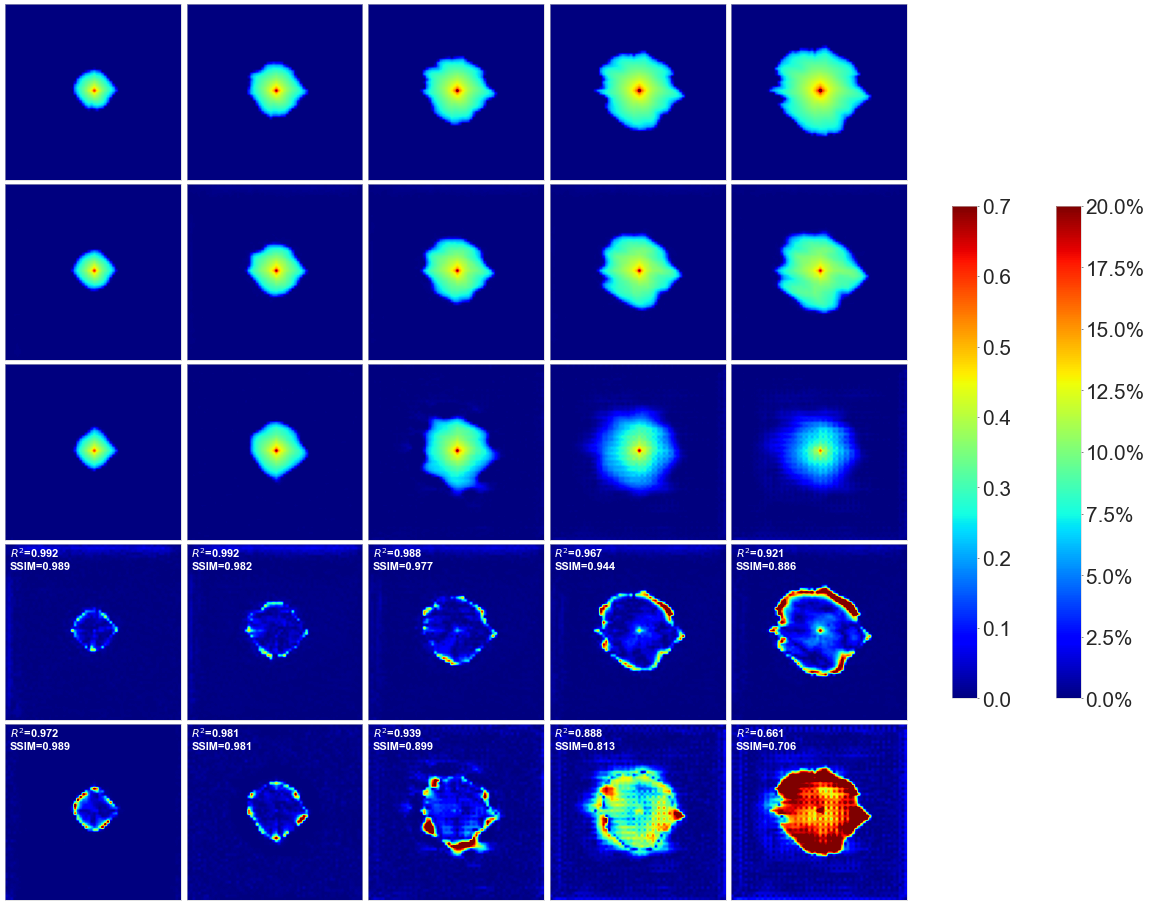

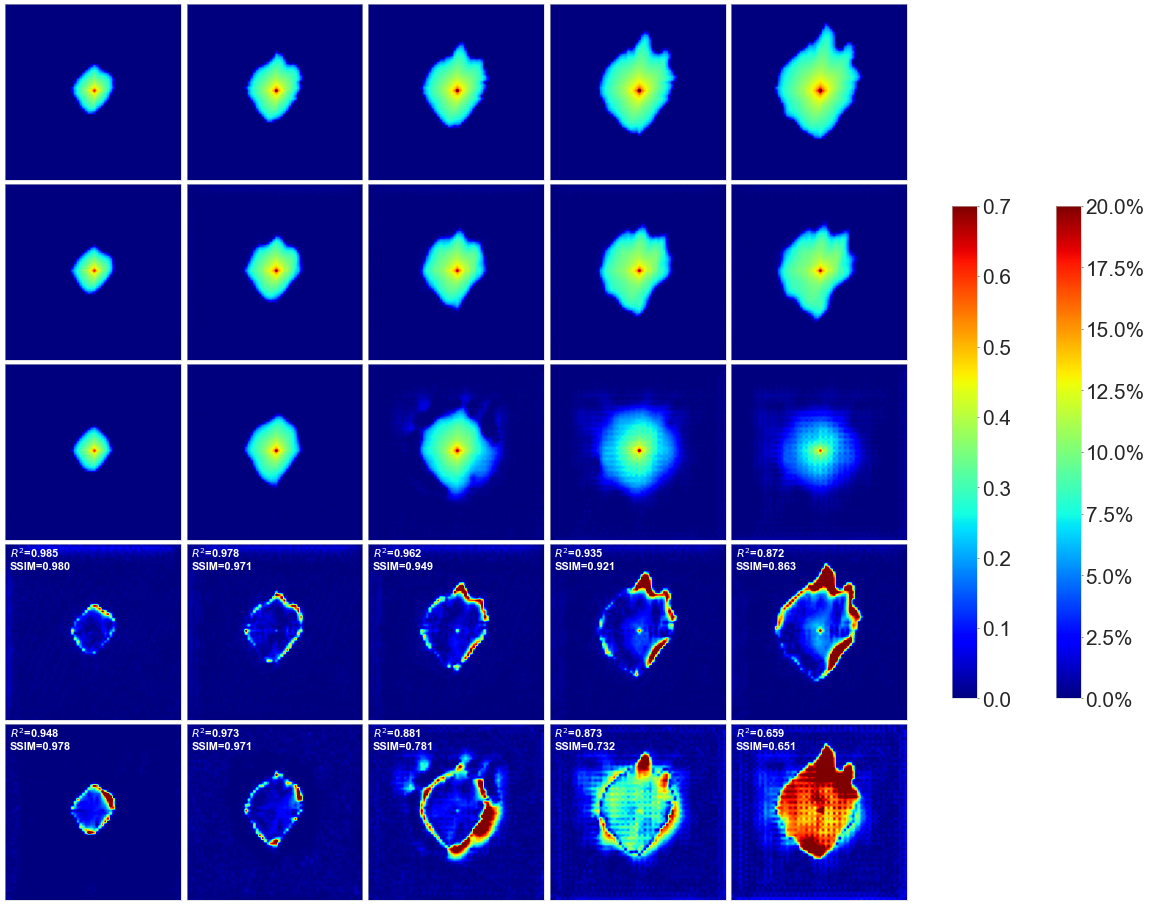

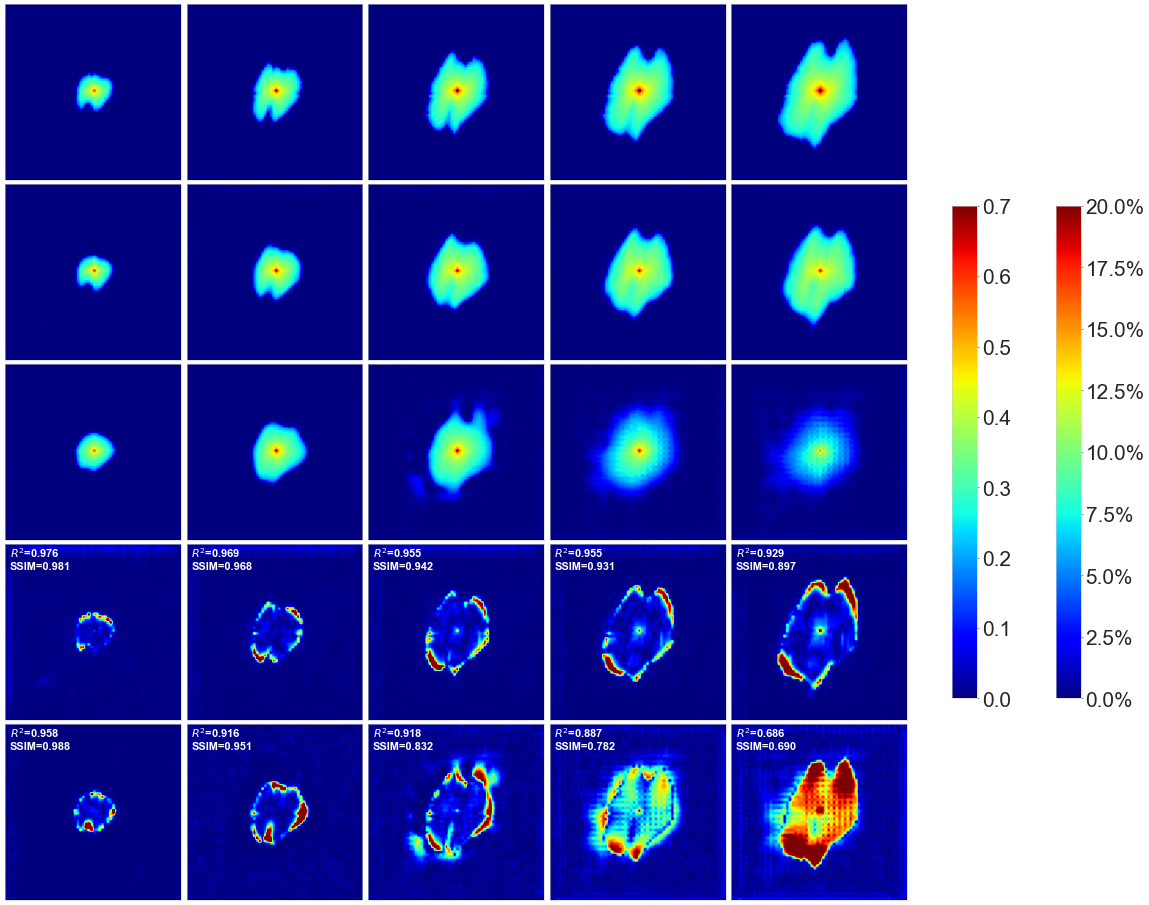

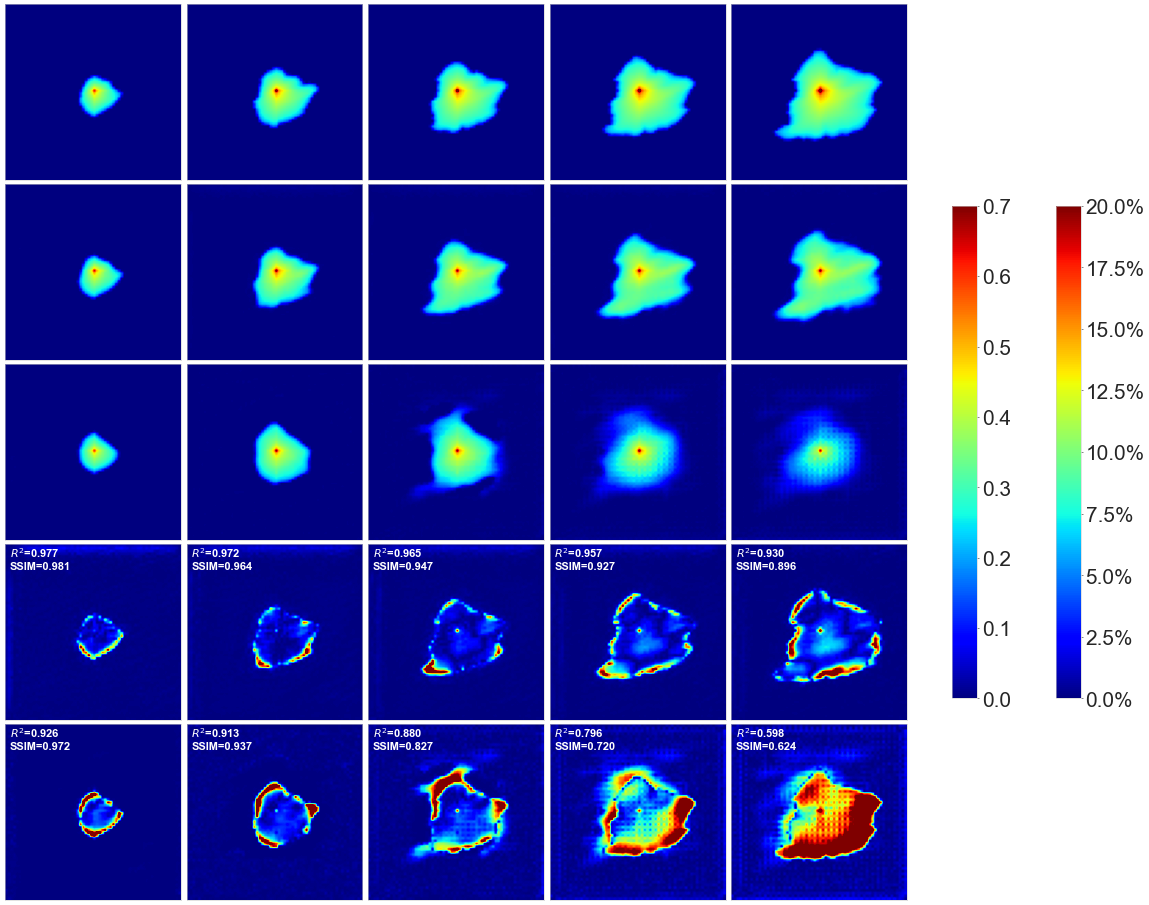

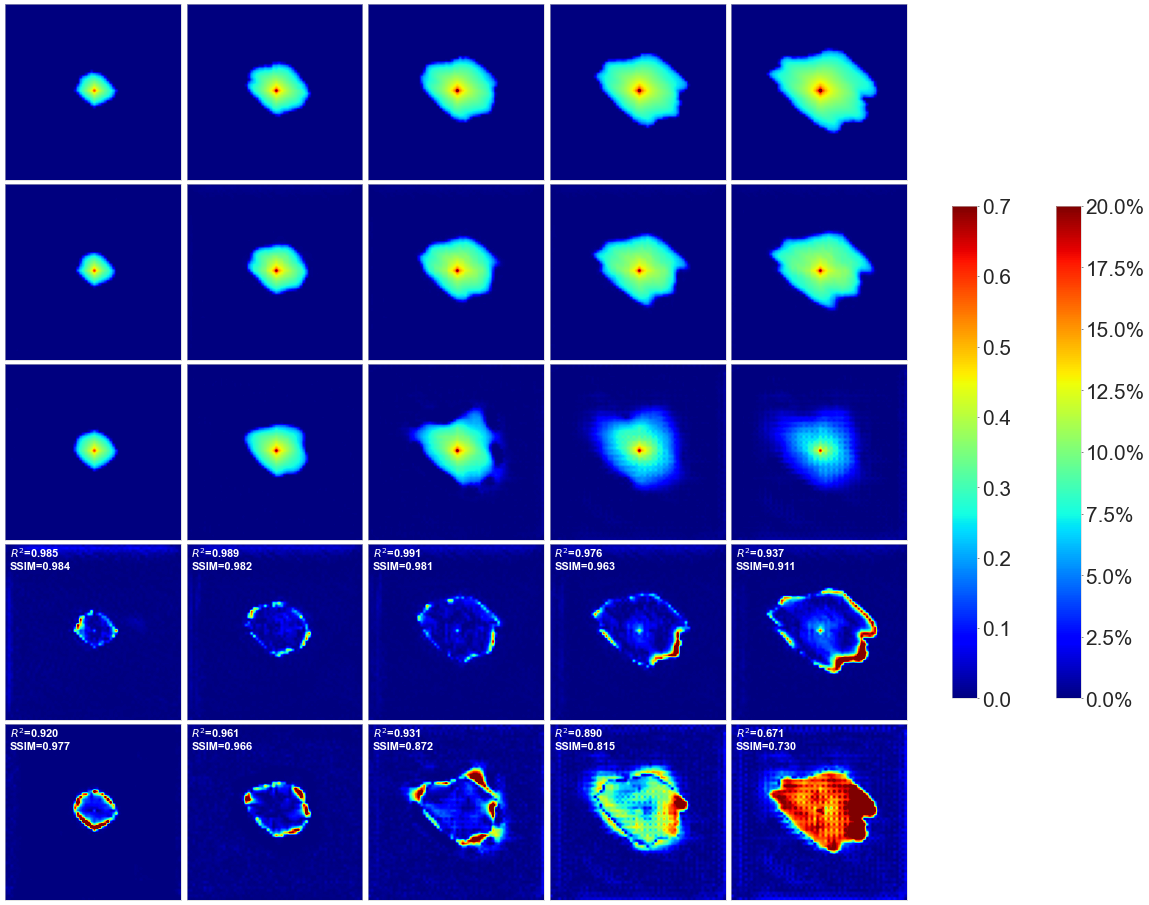

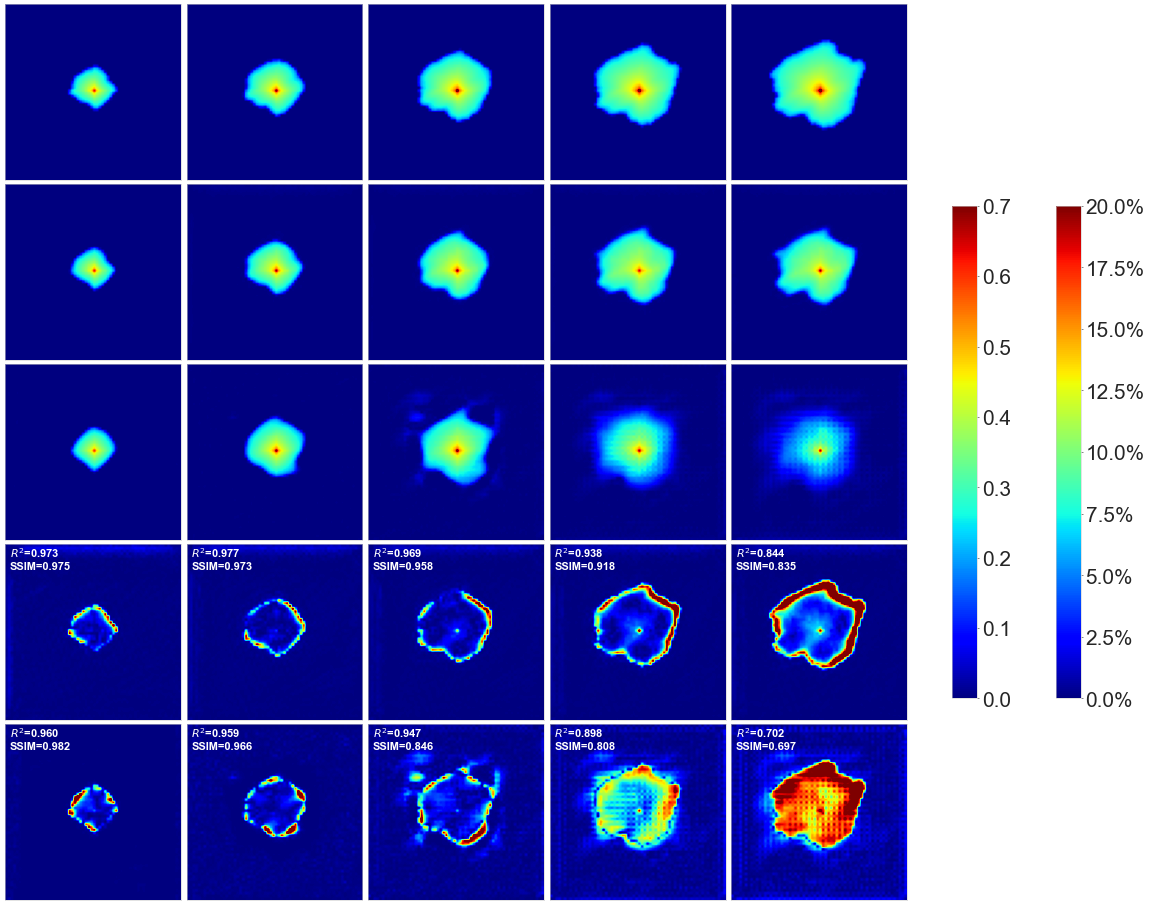

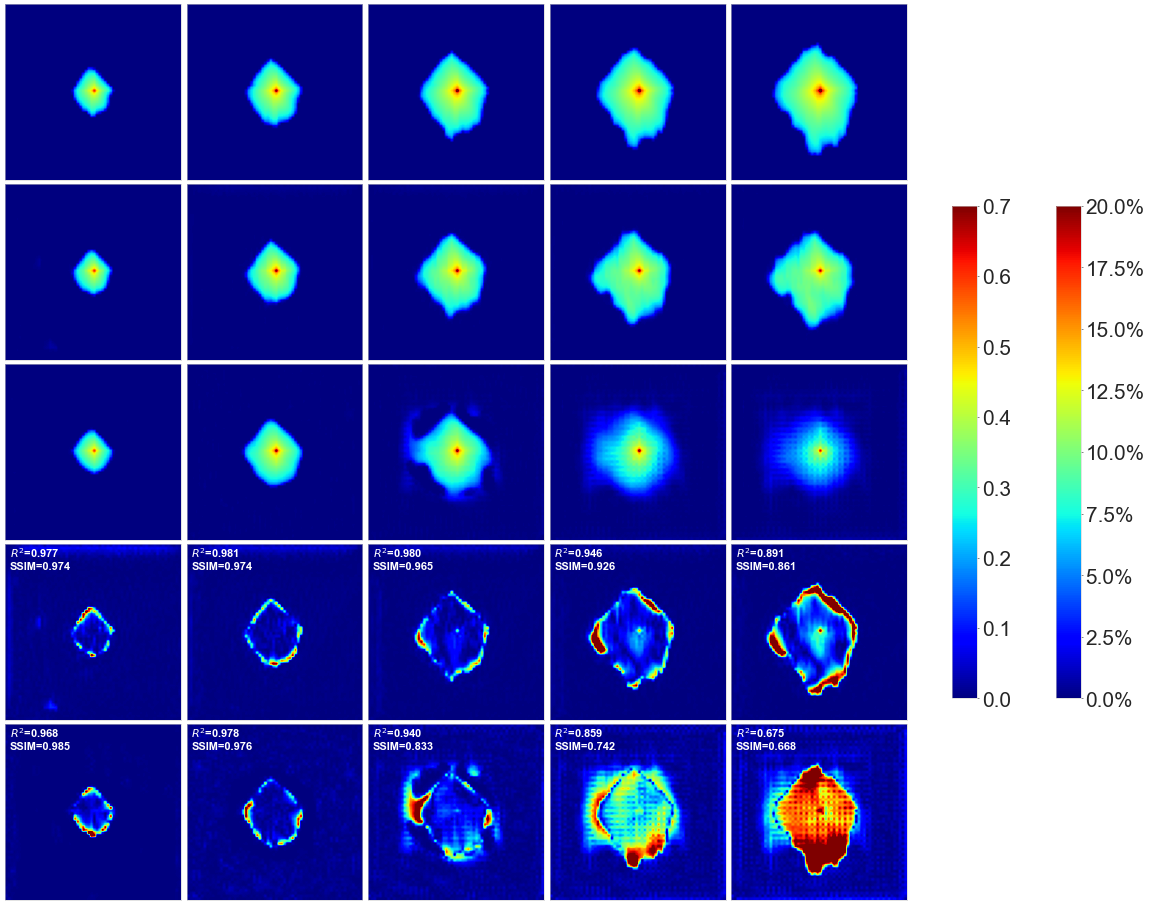

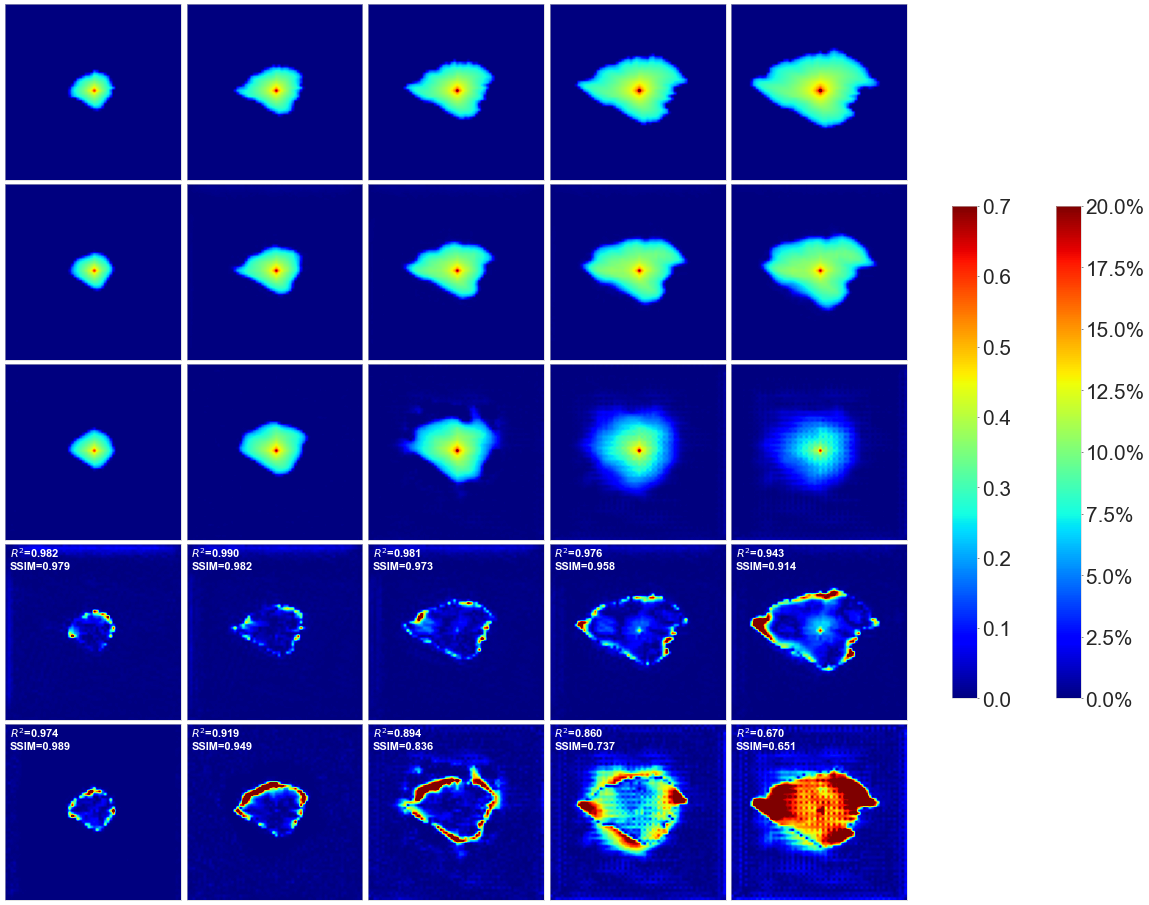

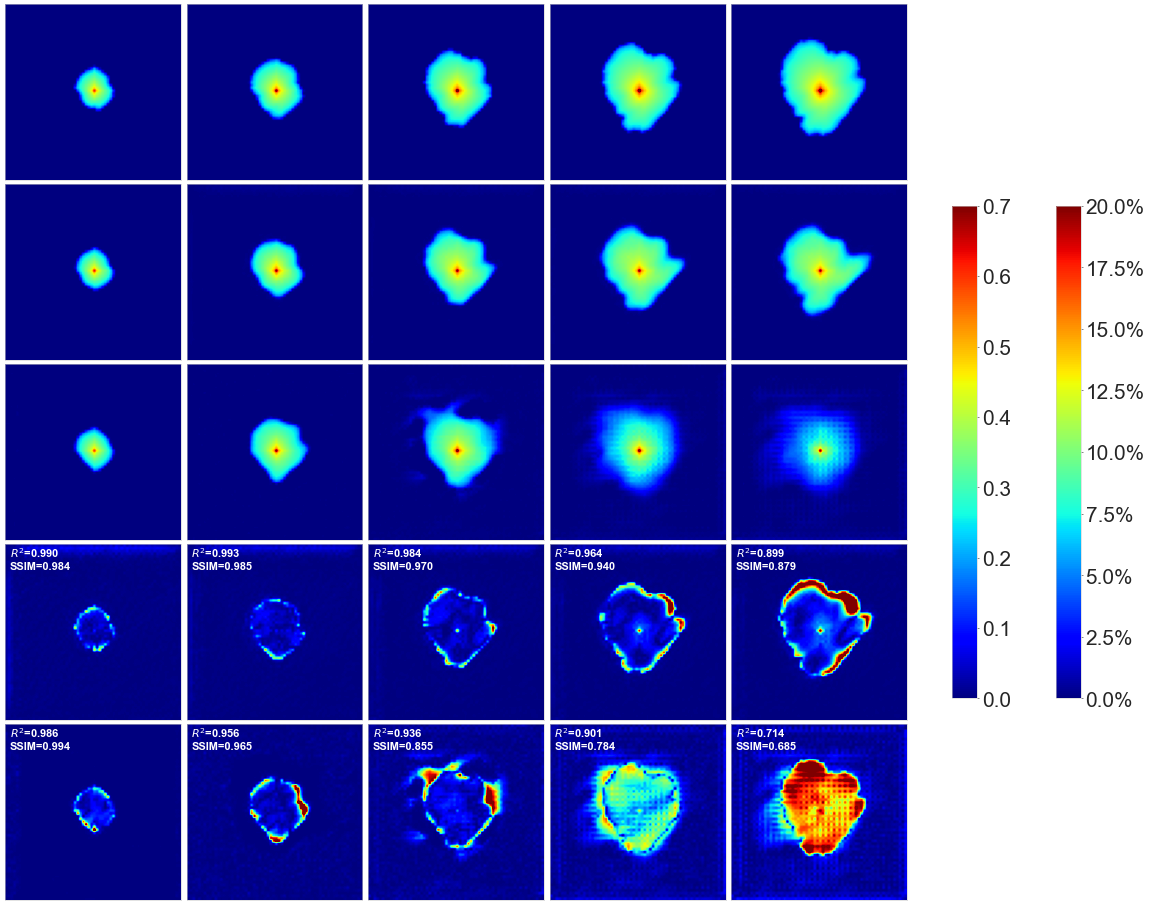

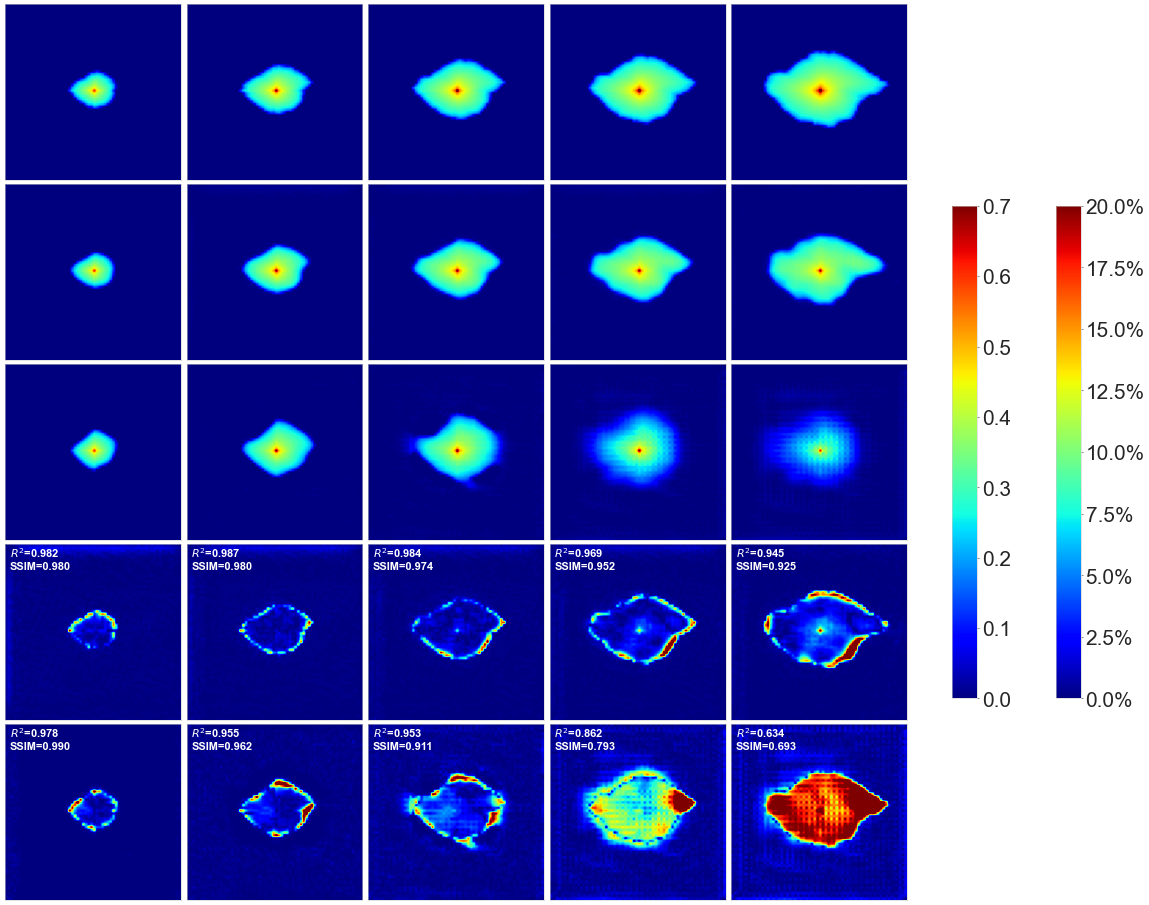

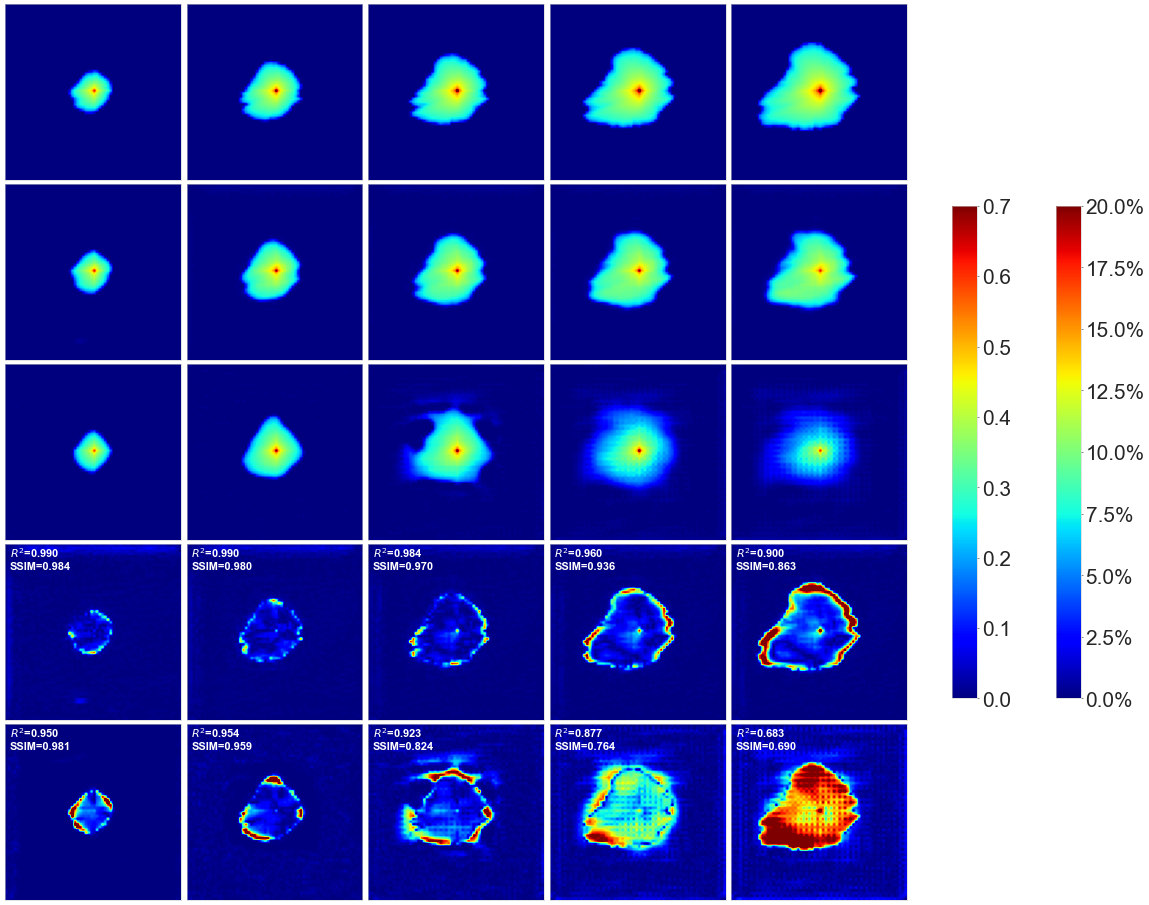

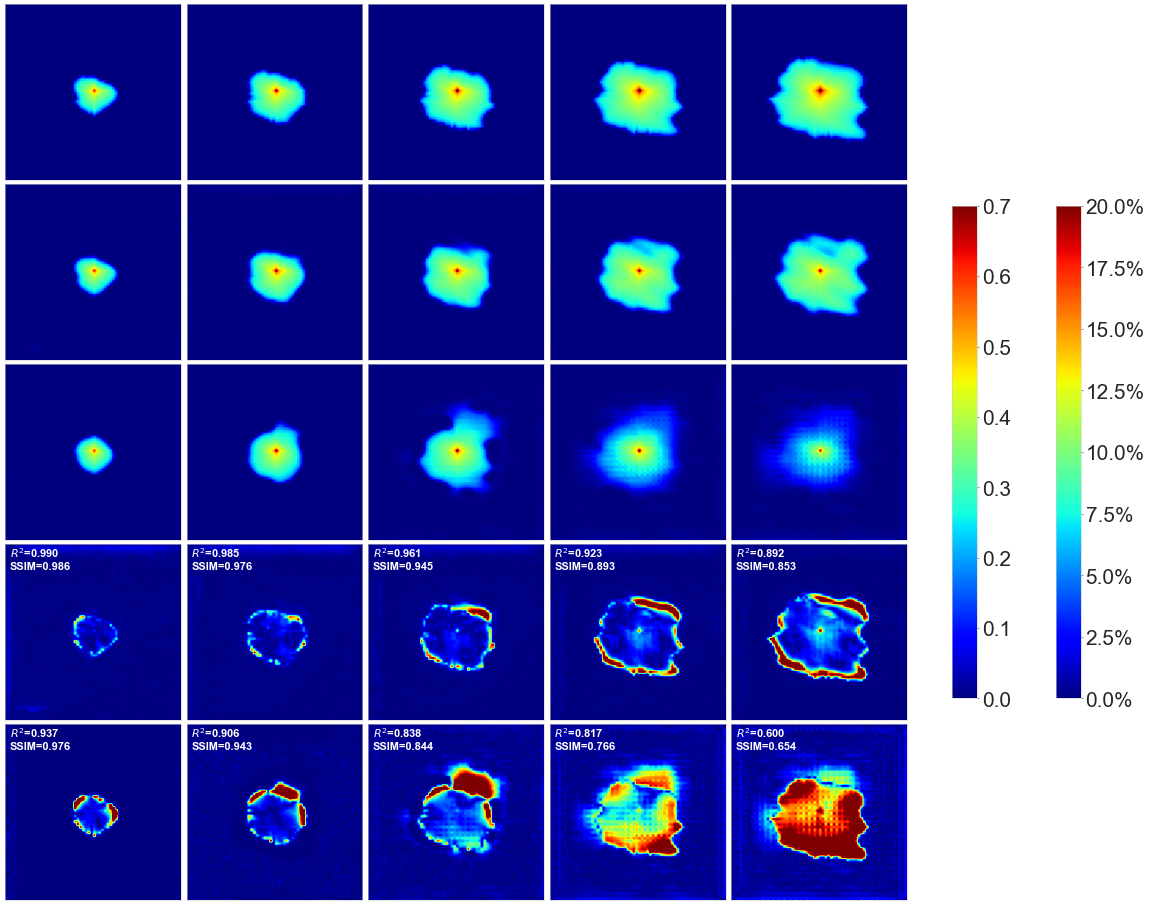

Error in callback <function flush_figures at 0x000001738AF5BD80> (for post_execute):


KeyboardInterrupt: 

In [17]:
for cc in np.arange(8000, 8250):
    plot_tmp(cc)